In [1]:
import pandas as pd
import gspread
import seaborn as sns
import matplotlib.pyplot as plt

from gspread_dataframe import get_as_dataframe, set_with_dataframe

gc = gspread.service_account("./google_credentials.json")

sheet_url = "https://docs.google.com/spreadsheets/d/1gQh8JVK2iBwmVsK5m3jXTDc69xZfPyMgHYbl3YH39Mk/"
worksheet_name = "Ответы на форму (1)"

s = gc.open_by_url(sheet_url)
w1 = s.worksheet(worksheet_name)
df_raw = get_as_dataframe(w1, evaluate_formulas=True)

In [2]:
sns.set_context("notebook")
sns.set_style("dark")

In [3]:
def clean_df(df):
    """Remove empty rows and columns, convert values in int_columns to integers"""
    df = df[pd.notnull(df.iloc[:, 0])]
    df = df.drop([col for col in df.columns if col.startswith("Unnamed")], axis=1)

    # Replacing unknown
    df = df.fillna('')

    return df

In [4]:
df = clean_df(df_raw)

In [5]:
df = df.drop(["Enter your Display Name if you want", "Anything you'd like to add?"], axis=1)

In [6]:
df

,Отметка времени,What ECR gameplay zone are you from (select most comfortable one if not from one of those)?,How often do you play ECR PvP (select closest option)?,"If you play rarely, how much would adding progression (EC-style, weapons/items, and customization options) increase your interest in ECR?",What are biggest ECR problems? [First biggest],What are biggest ECR problems? [Second],What are biggest ECR problems? [Third],Do you have turned on notifications about planned games and do you receive them with sound / red circle sign?,What's the largest player amount in one match you saw in ECR (both commands)?,Where is ECR progress on its completeness track?,...,How much are you waiting for Squads (within match)?,How much are you waiting for War Parties (lobbies)?,How much are you waiting for Preferred Faction selection?,How much are you waiting for in-game voice chat?,"How much are you waiting for new ground vehicles (Landraiders, Landspeeders, veteran tanks and MLRS)?",How much are you waiting for Drop Pods?,How much are you waiting for tank battles (considering 1 man control and better damage system)?,"How much would you like building destruction system, like in Battlebit?","How much would you like some kind of FPV drones, like in Battlebit?","Since ECR now has terminators, do you think ECR will have open world?"
0,09.03.2024 0:57:44,RU,Several times per week,I play often already,Space Marine feeling,Weapon feeling,Control over character (not map related),"Yes, I get pings, I didn't mute them, I often ...",30+,7.0,...,7.0,7.0,8.0,6.0,6.0,8.0,7.0,8.0,9.0,6.0
1,09.03.2024 1:14:16,EU,Once per month or more rarely,"I play rarely, but this would make me play mor...",Control over character (not map related),Lack of progression system,Monotonous gameplay,"I am not subscribed for pings, and I don't sig...",1-4,3.0,...,6.0,3.0,5.0,5.0,5.0,7.0,3.0,4.0,3.0,3.0
2,09.03.2024 1:16:52,EU,Only with largest updates,I play often already,Weapon feeling,Monotonous gameplay,Lack of progression system,"Yes, I get pings, I didn't mute them, I often ...",5-8,5.0,...,10.0,10.0,10.0,9.0,7.0,4.0,7.0,9.0,8.0,8.0
3,09.03.2024 1:16:53,RU,Several times per week,I play often already,Weapon feeling,Class balance,Monotonous gameplay,"Yes, I get pings, I didn't mute them, I often ...",9-14,3.0,...,9.0,9.0,8.0,6.0,5.0,6.0,9.0,8.0,8.0,5.0
4,09.03.2024 1:22:42,US,Only with largest updates,"I play rarely, and this wouldn't make me play ...",Weapon feeling,Class balance,FPS,"I am not subscribed for pings, and I don't sig...",21-29,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,09.03.2024 1:38:45,RU,Several times per month,"I play rarely, but this would make me play mor...",Ping,FPS,No problems (1),"Yes, I get pings, I didn't mute them, I often ...",30+,4.0,...,10.0,9.0,9.0,10.0,6.0,6.0,9.0,6.0,5.0,10.0
6,09.03.2024 1:49:24,US,At least once per week,"I play rarely, but this would make me play mor...",Class balance,Space Marine feeling,Weapon feeling,"I am not subscribed for pings, and I don't sig...",9-14,5.0,...,5.0,5.0,5.0,5.0,8.0,4.0,8.0,8.0,5.0,3.0
7,09.03.2024 1:52:08,EU,Several times per week,"I play rarely, but this would make me play mor...",Ping,FPS,Monotonous gameplay,"Yes, I get pings, I didn't mute them, I often ...",21-29,6.0,...,5.0,6.0,10.0,2.0,1.0,8.0,2.0,5.0,1.0,8.0
8,09.03.2024 1:53:01,US,Several times per month,"I play rarely, but this would make me play mor...",No problems (1),Lack of progression system,Ping,"Yes, I get pings, I didn't mute them, but I do...",15-20,6.0,...,10.0,10.0,10.0,10.0,3.0,10.0,3.0,10.0,7.0,5.0
9,09.03.2024 2:29:11,EU,At least once per week,"I play rarely, but this would make me play mor...",Weapon feeling,Space Marine feeling,Control over character (not map related),"Yes, I get pings, I didn't mute them, but I do...",30+,6.0,...,6.0,7.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
with open("columns.txt", "wb") as f:
    content = ""
    for c in df.columns:
        content += c + "\n"
    f.write(content.encode("utf-8"))

In [8]:
def draw_barplot(df_, column_name_, xtitle_, value_order_=None, rot_=0, align_="center", label_type_="edge"):
    s = df_[column_name_]
    s = s[s != ""]
    s  = s.value_counts().rename_axis(index=xtitle_)

    if isinstance(value_order_, dict):
        s = s.rename(value_order_)
        s = s.reindex(index=value_order_.values())
        s = s.iloc[::-1]
    elif isinstance(value_order_, list):
        s = s.reindex(index=value_order_)
        s = s.iloc[::-1]

    if value_order_ is None:
        s = s.sort_values()

    ax = s.plot.barh(rot=rot_, align=align_)
    ax.bar_label(ax.containers[0], label_type=label_type_)
    plt.show()

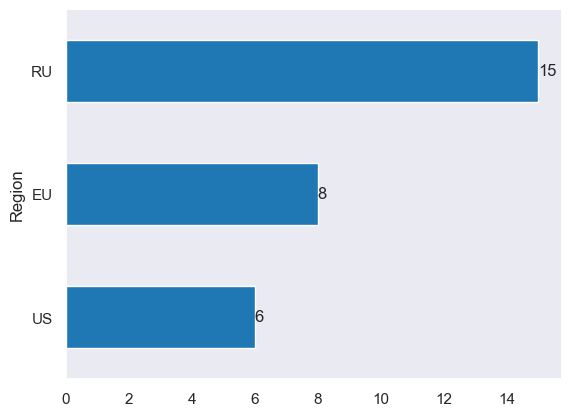

In [9]:
q1_region = "What ECR gameplay zone are you from (select most comfortable one if not from one of those)?"
draw_barplot(df, q1_region, "Region")

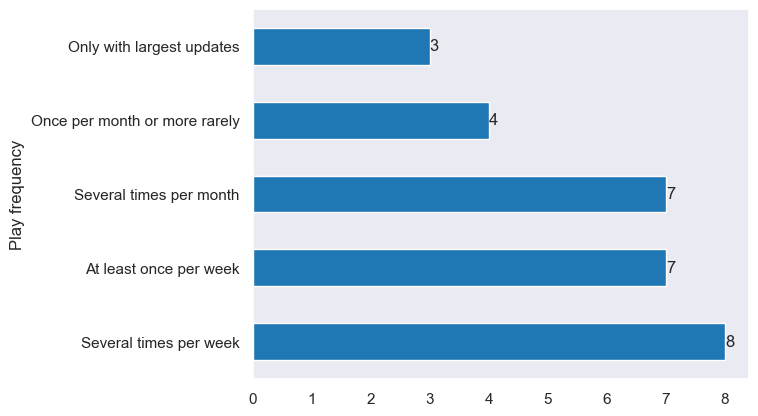

In [10]:
q2_play_frequency = "How often do you play ECR PvP (select closest option)?"
q2_vo = [
    'Only with largest updates',
    'Once per month or more rarely',
    'Several times per month',
    'At least once per week',
    'Several times per week'
]
draw_barplot(df, q2_play_frequency, "Play frequency", value_order_=q2_vo)

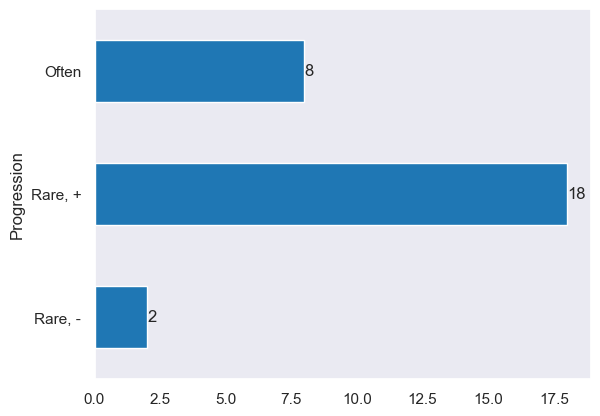

In [11]:
q3_progression = "If you play rarely, how much would adding progression (EC-style, weapons/items, and customization options) increase your interest in ECR?"
q3_vo = {
    "I play often already": "Often",
    "I play rarely, but this would make me play more often": "Rare, +",
    "I play rarely, and this wouldn't make me play more often": "Rare, -"
}
draw_barplot(df, q3_progression, "Progression", value_order_=q3_vo)

In [12]:
def draw_score_question(df_, column_names_, xtitle_, value_order_=None, rot_=0, align_="center", label_type_="edge"):
    final_s = pd.Series()
    for column_name_, score_ in column_names_.items():
        s = df_[column_name_].value_counts().rename_axis(index=xtitle_)

        if isinstance(value_order_, dict):
            s = s.rename(value_order_)
            s = s.reindex(index=value_order_.values())
        elif isinstance(value_order_, list):
            s = s.reindex(index=value_order_)

        s = s * score_

        final_s = final_s.add(s, fill_value=0)

    final_s = final_s.drop("", errors="ignore")
    if value_order_ is None:
        final_s = final_s.sort_values()

    ax = final_s.plot.barh(rot=rot_, align=align_)
    ax.bar_label(ax.containers[0], label_type=label_type_)
    plt.show()

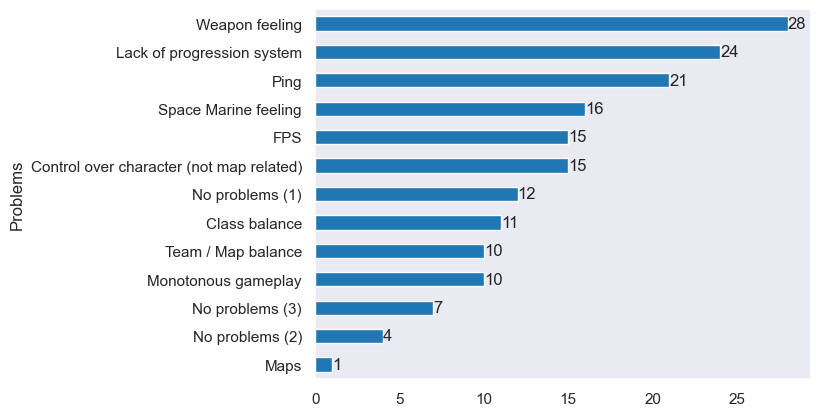

In [13]:
q4_problems = {
    "What are biggest ECR problems? [First biggest]": 3,
    "What are biggest ECR problems? [Second]": 2,
    "What are biggest ECR problems? [Third]": 1
}
draw_score_question(df, q4_problems, "Problems", rot_=0)

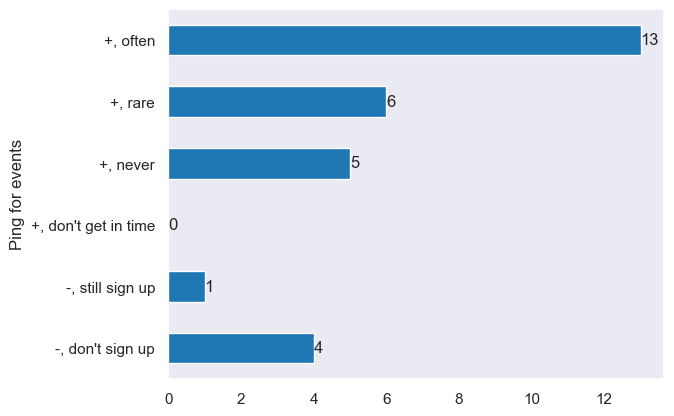

In [14]:
q5_pings = "Do you have turned on notifications about planned games and do you receive them with sound / red circle sign? "
q5_vo = {
    "Yes, I get pings, I didn't mute them, I often (>30% cases for my zone) sign up for events": "+, often",
    "Yes, I get pings, I didn't mute them, but I don't often sign up (<30% cases for my zone)": "+, rare",
    "Yes, I get pings, I didn't mute them, but I never or very rarely sign up": "+, never",
    "No, I am subscribed for pings, but I mostly don't get notifications in time": "+, don't get in time",
    "I am not subscribed for pings, but I still sign up for events": "-, still sign up",
    "I am not subscribed for pings, and I don't sign up for events": "-, don't sign up"
}
draw_barplot(df, q5_pings, "Ping for events", value_order_=q5_vo)

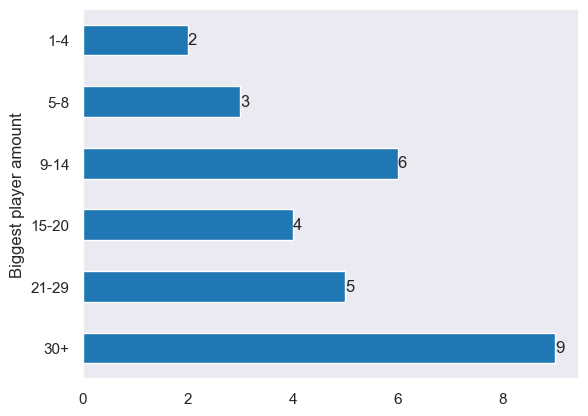

In [15]:
q6_largest_pa = "What's the largest player amount in one match you saw in ECR (both commands)?"
q6_vo = [
    "1-4",
    "5-8",
    "9-14",
    "15-20",
    "21-29",
    "30+"
]
draw_barplot(df, q6_largest_pa, "Biggest player amount", value_order_=q6_vo)

In [16]:
def draw_scale_question(df_, header_, extra_title_=None):
    s = df_[header_]
    s = s[s != ""]

    plt.scatter([s.mean()], [0], color='black', label='Mean', s=100, marker='o')
    plt.errorbar(s.mean(), 0, xerr=s.std(), fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
    plt.title(f"{extra_title_ if extra_title_ else header_}: {s.mean():.2f} +- {s.std():.2f}")

    ax = plt.gca()
    ax.set_xlim([0, 10])
    ax.set_yticks([])

    fig = plt.gcf()
    fig.set_size_inches(6, 1)

    plt.show()

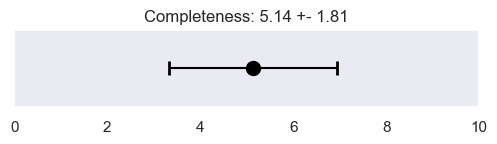

In [17]:
q7_completeness = "Where is ECR progress on its completeness track?"
draw_scale_question(df, q7_completeness, "Completeness")

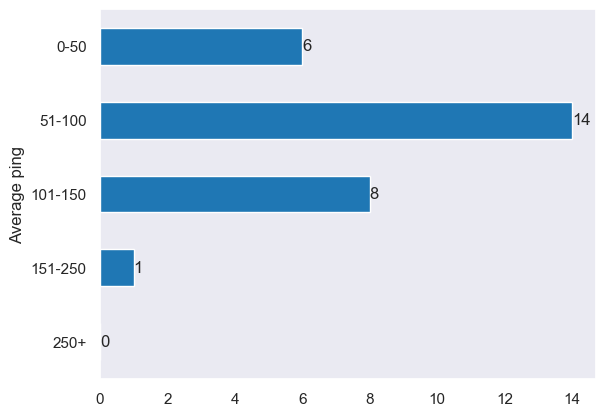

In [18]:
q8_avg_ping = "What's your average ping when playing on most comfortable ECR PvP Server (RU/EU/US)?"
q8_vo = [
    "0-50",
    "51-100",
    "101-150",
    "151-250",
    "250+"
]
draw_barplot(df, q8_avg_ping, "Average ping", value_order_=q8_vo)

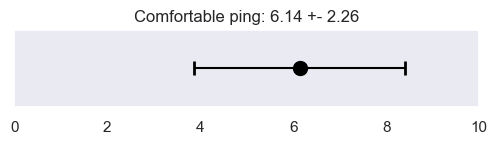

In [19]:
q9_ping_comfortable = "Rate how comfortable your ping is while playing ECR PvP"
draw_scale_question(df, q9_ping_comfortable, "Comfortable ping")

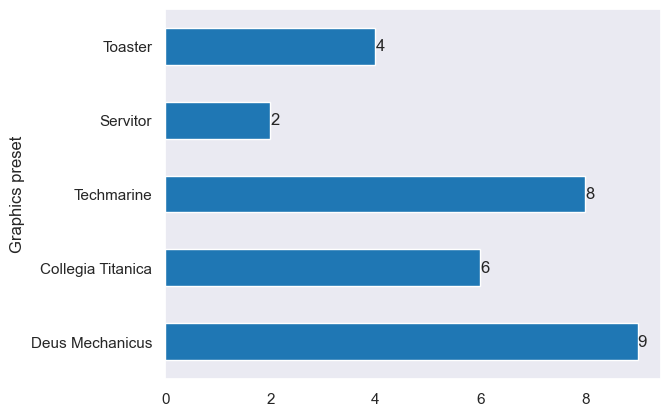

In [20]:
q10_graphics_preset = "What graphic preset do you play on?"
q10_vo = [
    "Toaster",
    "Servitor",
    "Techmarine",
    "Collegia Titanica",
    "Deus Mechanicus"
]
draw_barplot(df, q10_graphics_preset, "Graphics preset", value_order_=q10_vo)

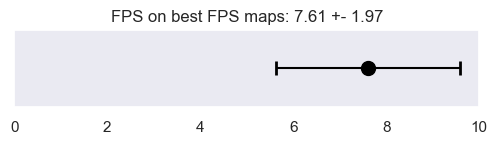

In [21]:
q11_fps_best = "Rate how comfortable your FPS is on the most optimized maps (Canyon / Promethium / Nexus / ...)"
draw_scale_question(df, q11_fps_best, "FPS on best FPS maps")

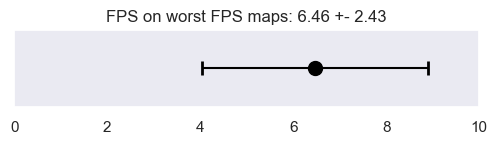

In [22]:
q12_fps_worst = "Rate how comfortable your FPS is on the least optimized maps, considering you tried to lower graphics preset after entering it (Salvation / Blackbolt / ...)"
draw_scale_question(df, q12_fps_worst, "FPS on worst FPS maps")

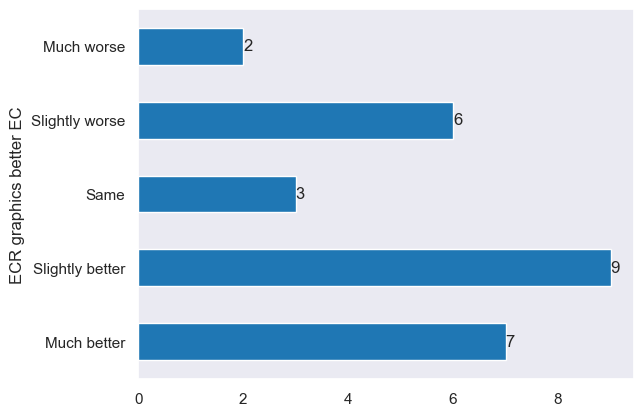

In [23]:
q13_ecr_graphics_better = "How much are ECR graphics better than EC?"
q13_vo = [
    "Much worse",
    "Slightly worse",
    "Same",
    "Slightly better",
    "Much better"
]
draw_barplot(df, q13_ecr_graphics_better, "ECR graphics better EC", value_order_=q13_vo)

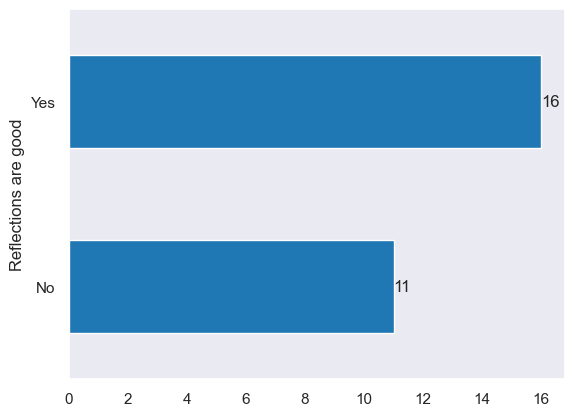

In [24]:
q14_reflections = "Are ECR reflections (in water, metal, etc.) better than lack of them in EC?"
draw_barplot(df, q14_reflections, "Reflections are good")

In [25]:
def draw_scale_question_grouped(df_, headers_, title_):
    headers_ = reversed(headers_)

    yticks = []
    ylabels = []

    for i, header_ in enumerate(headers_):
        s = df_[header_]
        s = s[s != ""]

        plt.scatter([s.mean()], [i], color='black', label='Mean', s=100, marker='o')
        plt.errorbar(s.mean(), i, xerr=s.std(), fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')
        yticks.append(i)
        ylabels.append(header_)

    plt.title(title_)

    ax = plt.gca()
    ax.set_xlim([0, 10])
    ax.set_yticks(yticks, ylabels)

    plt.show()

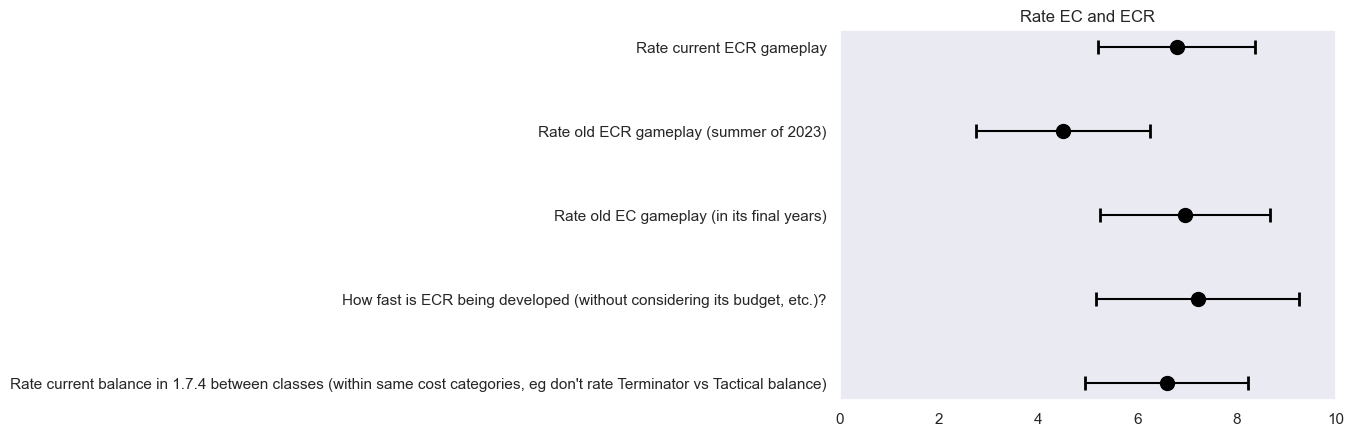

In [26]:
q15_q19 = [
    "Rate current ECR gameplay",
    "Rate old ECR gameplay (summer of 2023)",
    "Rate old EC gameplay (in its final years)",
    "How fast is ECR being developed (without considering its budget, etc.)?",
    "Rate current balance in 1.7.4 between classes (within same cost categories, eg don't rate Terminator vs Tactical balance)"
]

draw_scale_question_grouped(df, q15_q19, "Rate EC and ECR")

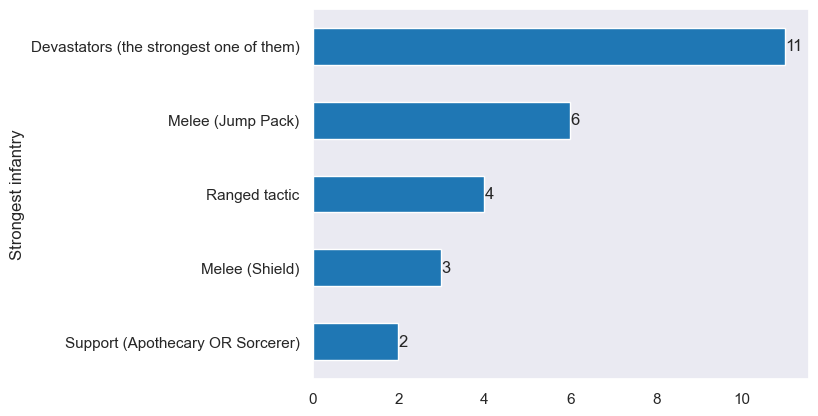

In [27]:
q20_strongest_infantry = "Who is the strongest standard class in 1.7.4?"
draw_barplot(df, q20_strongest_infantry, "Strongest infantry")

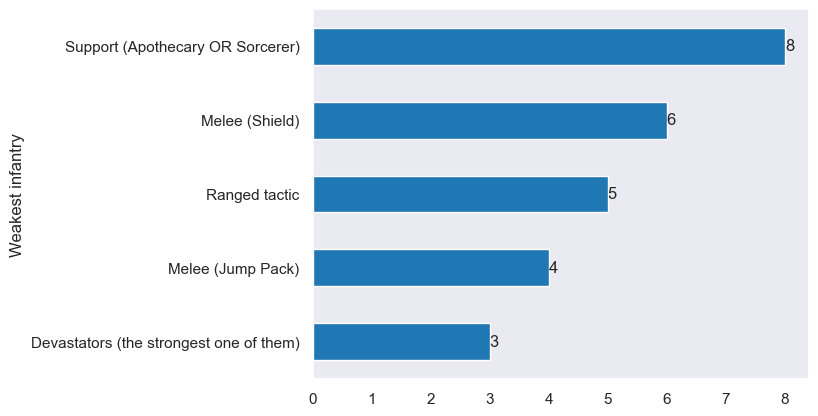

In [28]:
q21_weakest_infantry = "Who is the weakest standard class in 1.7.4?"
draw_barplot(df, q21_weakest_infantry, "Weakest infantry")

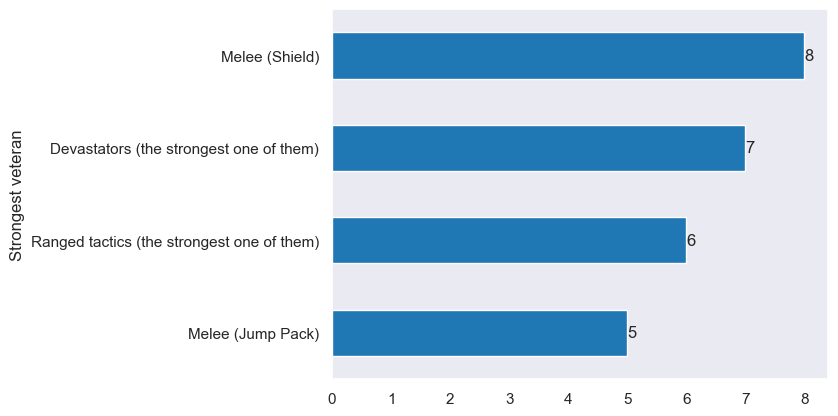

In [29]:
q22_strongest_vet = "Who is the strongest veteran class in 1.7.4?"
draw_barplot(df, q22_strongest_vet, "Strongest veteran")

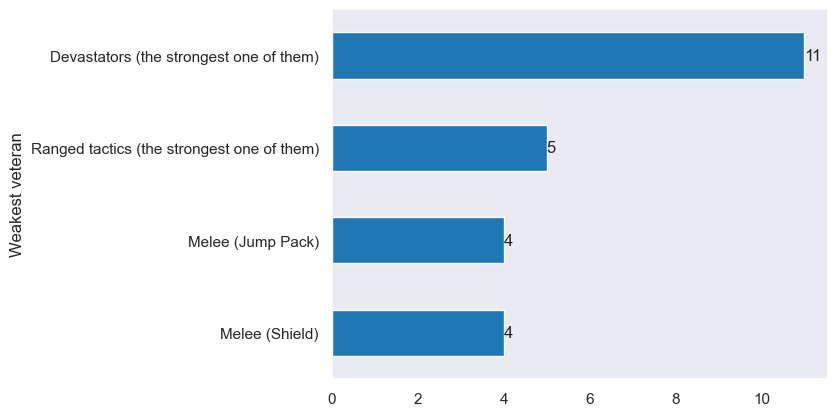

In [30]:
q23_weakest_vet = "Who is the weakest veteran class in 1.7.4?"
draw_barplot(df, q23_weakest_vet, "Weakest veteran")

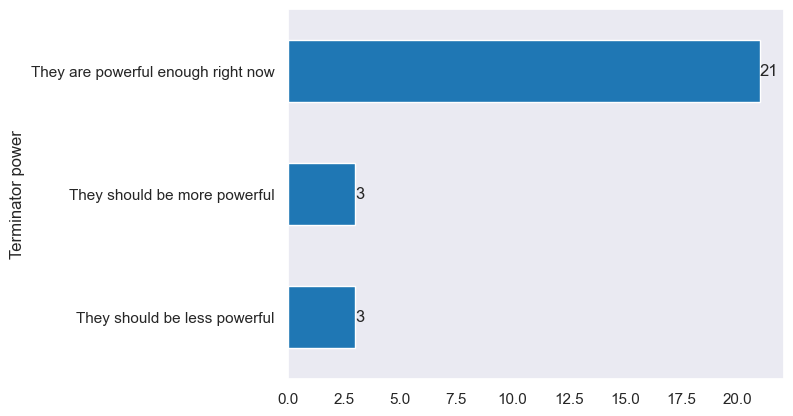

In [31]:
q24_terminator_power = "How much powerful should be Terminators (not considering their current cost)?"
draw_barplot(df, q24_terminator_power, "Terminator power")

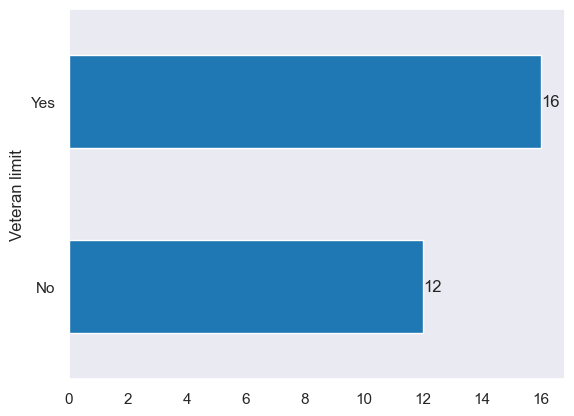

In [32]:
q25_veteran_problem = "Do you think that amount of veterans should be limited for player by spawn amount / by time he can play on them?"
draw_barplot(df, q25_veteran_problem, "Veteran limit")

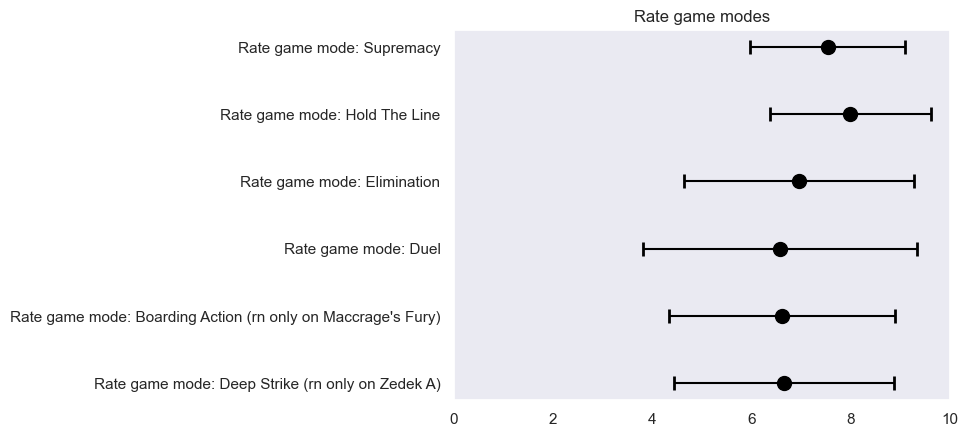

In [33]:
q26_q31_modes = [
    "Rate game mode: Supremacy",
    "Rate game mode: Hold The Line",
    "Rate game mode: Elimination",
    "Rate game mode: Duel",
    "Rate game mode: Boarding Action (rn only on Maccrage's Fury)",
    "Rate game mode: Deep Strike (rn only on Zedek A)"
]
draw_scale_question_grouped(df, q26_q31_modes, "Rate game modes")

In [34]:
def draw_score_table_question(df_, column_names_, xtitle_, score_dict_, rot_=0, align_="center", label_type_="edge"):
    final_dict = {}
    for column_name_, new_column_name_ in column_names_.items():
        s = df_[column_name_].value_counts().rename_axis(index=column_name_)

        s = s.filter(items=list(score_dict_.keys()))
        s = s.replace(score_dict_)
        s = s.rename_axis(index=column_name_)

        final_dict[new_column_name_] = s.sum()

    final_s = pd.Series(final_dict)
    final_s = final_s.sort_values()

    ax = final_s.plot.barh(rot=rot_, align=align_)
    ax.bar_label(ax.containers[0], label_type=label_type_)

    plt.title(xtitle_)
    plt.show()

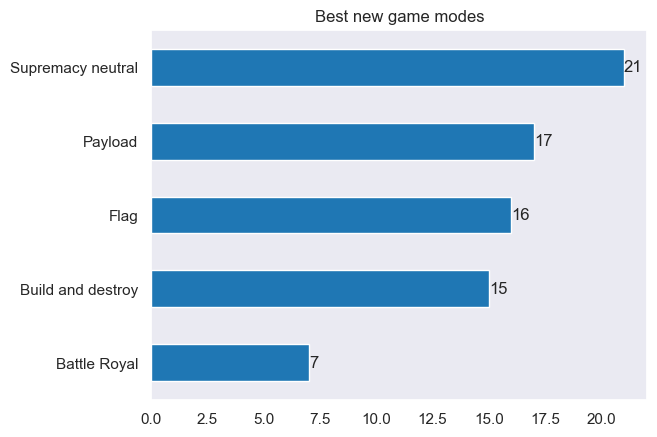

In [35]:
q32_new_game_modes = {
    "Rate possible stylized for Warhammer game modes to add to ECR [Capture the Flag]": "Flag",
    "Rate possible stylized for Warhammer game modes to add to ECR [Payload (accompany something moving, cart in TF2)]": "Payload",
    "Rate possible stylized for Warhammer game modes to add to ECR [Battle Royal]": "Battle Royal",
    "Rate possible stylized for Warhammer game modes to add to ECR [Attack/Defend with equal controlled objectives in the beginning]": "Supremacy neutral",
    "Rate possible stylized for Warhammer game modes to add to ECR [Build something (eg base) in any place and find and destroy enemy things]": "Build and destroy"
}

q32_vo = {
    "Feels like a good idea": 1,
    "Very good idea": 2
}
draw_score_table_question(df, q32_new_game_modes, "Best new game modes", q32_vo, rot_=0)

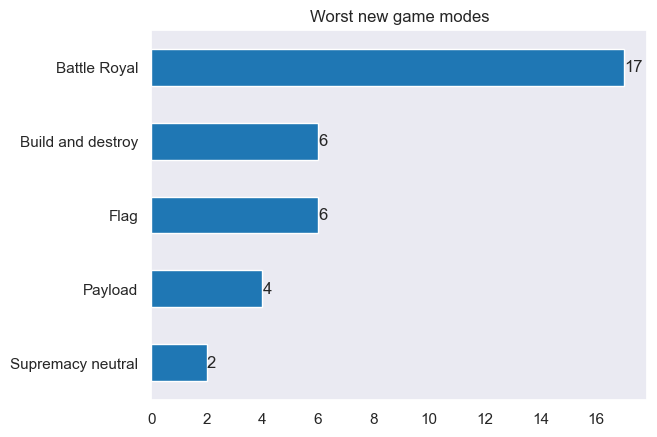

In [36]:
q32_vo_bad = {
    "Feels like a bad idea": 1,
    "Very bad idea": 2
}
draw_score_table_question(df, q32_new_game_modes, "Worst new game modes", q32_vo_bad, rot_=0)

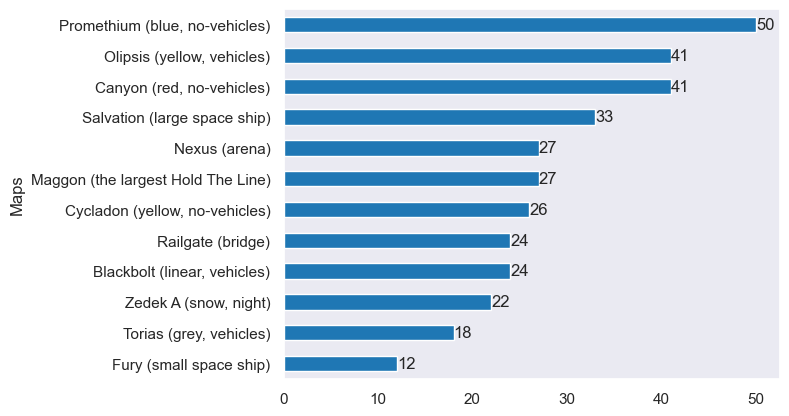

In [37]:
q33_rate_maps = {
    "Select top-5 best maps in ECR (by level design and gameplay, don't consider optimization, mission balance, etc.). They go in the same order as in match creation in ECR 1.7.4 [First]": 5,
    "Select top-5 best maps in ECR (by level design and gameplay, don't consider optimization, mission balance, etc.). They go in the same order as in match creation in ECR 1.7.4 [Second]": 4,
    "Select top-5 best maps in ECR (by level design and gameplay, don't consider optimization, mission balance, etc.). They go in the same order as in match creation in ECR 1.7.4 [Third]": 3,
    "Select top-5 best maps in ECR (by level design and gameplay, don't consider optimization, mission balance, etc.). They go in the same order as in match creation in ECR 1.7.4 [Fourth]": 2,
    "Select top-5 best maps in ECR (by level design and gameplay, don't consider optimization, mission balance, etc.). They go in the same order as in match creation in ECR 1.7.4 [Fifth]": 1
}
draw_score_question(df, q33_rate_maps, "Maps")

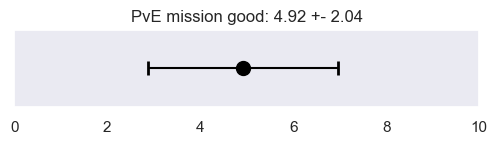

In [38]:
q34_pve_good = "Rate how good is current PvE mission (Forge of the Molten Vein: Horde)"
draw_scale_question(df, q34_pve_good, "PvE mission good")

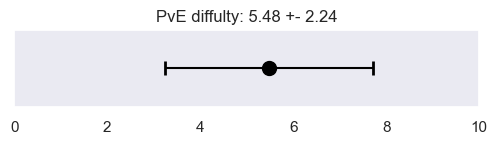

In [39]:
q35_pve_difficult = "Rate how difficult is current PvE mission (Forge of the Molten Vein: Horde), in 1.7.4 after amount of tyranids was decreased. Consider normal PvE classes (not melee)"
draw_scale_question(df, q35_pve_difficult, "PvE diffulty")

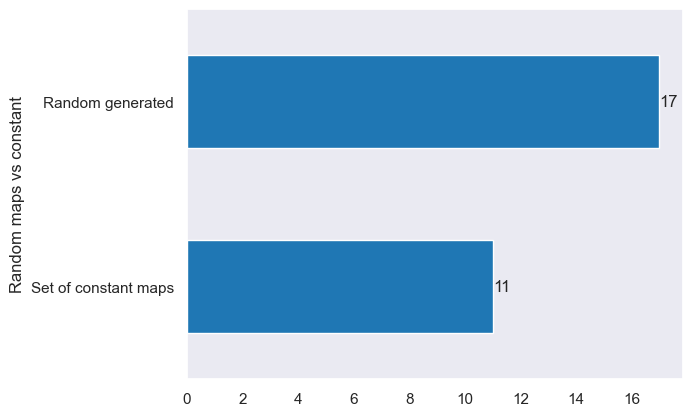

In [40]:
q36_random_maps = "What would you prefer as PvE maps: random generated maps with endless possible amount, but lower uniqueness (like in EC Lair missions) or a set of ready maps (smaller count, but they are more distringuished)"
draw_barplot(df, q36_random_maps, "Random maps vs constant")

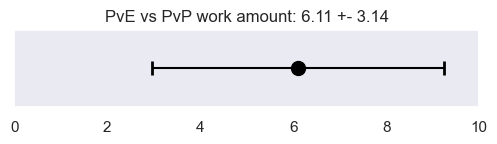

In [41]:
q37_pve_vs_pvp = "How much amount of work should be spread across PvE (more PvE maps, quests, enemies, etc.) and PvP (more PvP maps, more PvP vehicles, mechanics, etc.)"
draw_scale_question(df, q37_pve_vs_pvp, "PvE vs PvP work amount")

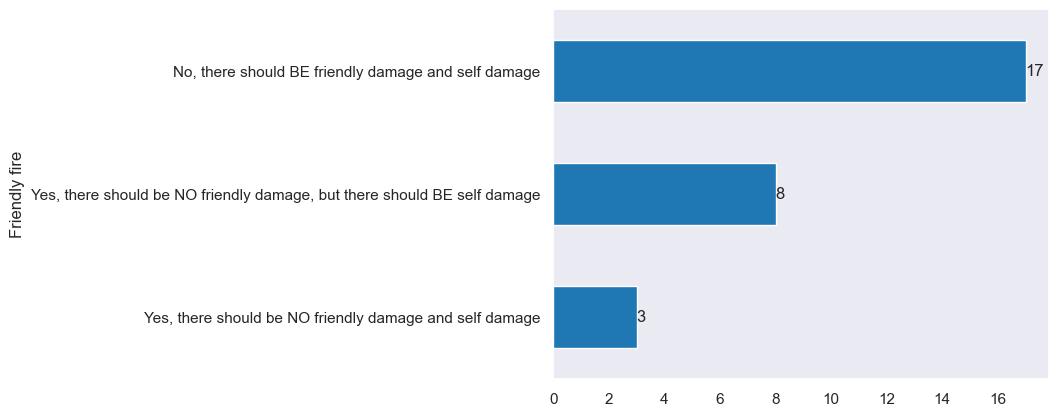

In [42]:
q38_friendly_fire = "Would you like if we removed friendly fire damage?"
draw_barplot(df, q38_friendly_fire, "Friendly fire")

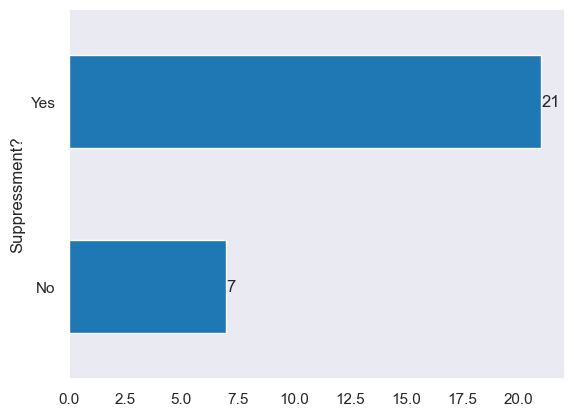

In [43]:
q39_suppressment = "Should suppressing mechanic from EC exist in ECR (when bullets from heavy bolter fly near you, you get debuff to your shooting accuracy)?"
draw_barplot(df, q39_suppressment, "Suppressment?")

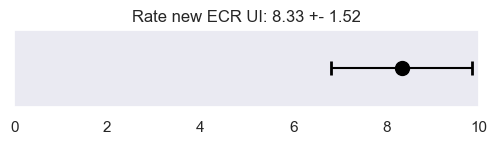

In [44]:
q40_new_ui = "Rate new ECR UI (considering you'll be able to customize weapon crosshair in the future)"
draw_scale_question(df, q40_new_ui, "Rate new ECR UI")

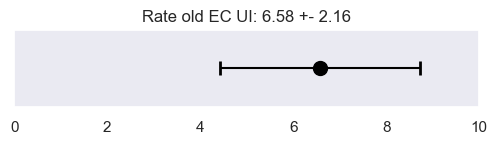

In [45]:
q41_old_ec_ui = "Rate old EC UI"
draw_scale_question(df, q41_old_ec_ui, "Rate old EC UI")

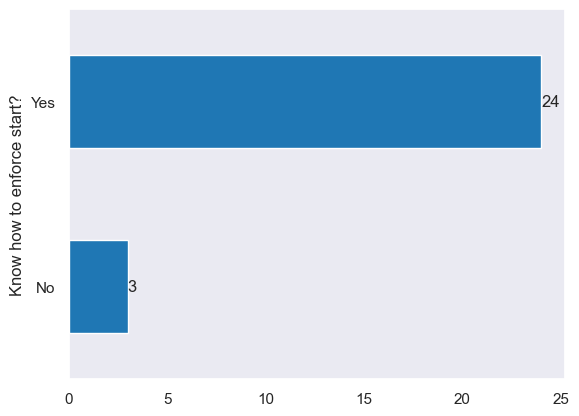

In [46]:
q42_enforce_start = "Do you know how to enforce match start as a host (considering you hosted at least 1 match)?"
draw_barplot(df, q42_enforce_start, "Know how to enforce start?")

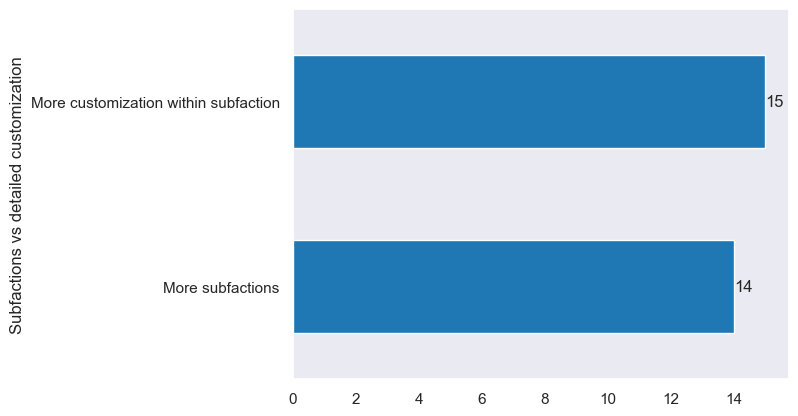

In [47]:
q43_more_subfactions_vs_cust = "What would you prefer: more subfactions (chapters / legions / etc.) or more customization options within 1 subfaction (more - comparing to old EC)?"
draw_barplot(df, q43_more_subfactions_vs_cust, "Subfactions vs detailed customization")

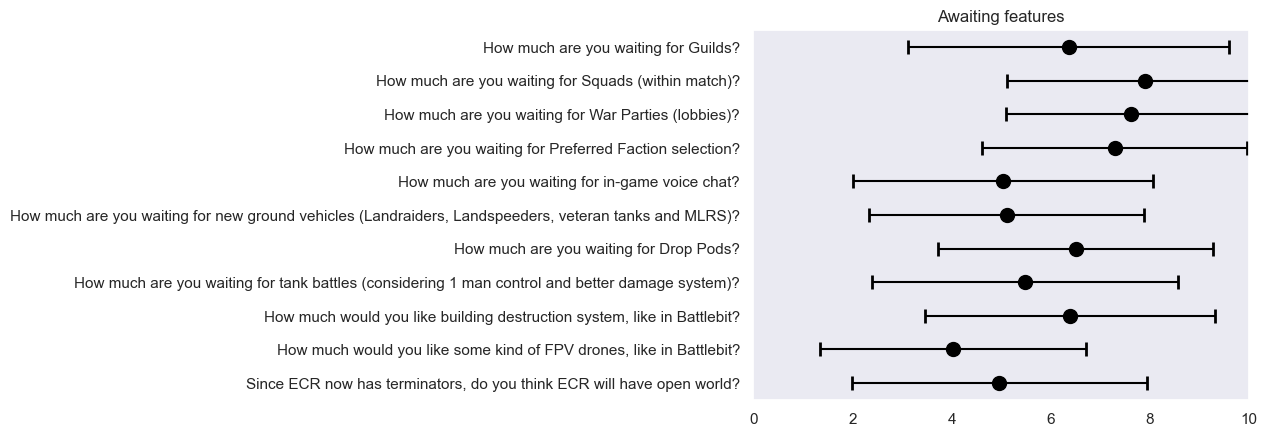

In [48]:
q44_q54 = [
    "How much are you waiting for Guilds?",
    "How much are you waiting for Squads (within match)?",
    "How much are you waiting for War Parties (lobbies)?",
    "How much are you waiting for Preferred Faction selection?",
    "How much are you waiting for in-game voice chat?",
    "How much are you waiting for new ground vehicles (Landraiders, Landspeeders, veteran tanks and MLRS)?",
    "How much are you waiting for Drop Pods?",
    "How much are you waiting for tank battles (considering 1 man control and better damage system)?",
    "How much would you like building destruction system, like in Battlebit?",
    "How much would you like some kind of FPV drones, like in Battlebit?",
    "Since ECR now has terminators, do you think ECR will have open world?"
]

draw_scale_question_grouped(df, q44_q54, "Awaiting features")